# Part 1: Autoencoder

In [61]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

## The Fashion-MNIST Dataset

Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement of the original MNIST dataset for benchmarking machine learning algorithms as it is a more challenging dataset. 

For this lab, let's start by loading the Fashion-MNIST dataset using the Torchvision library. When loading, we can transform the images to be flattened vectors of dimension 784 (= 28 x 28).

Once the data has been downloaded, we can plot some of the examples to see what the classes look like.

### Loading the Dataset using PyTorch and the Torchvision Library

In [62]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 256

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

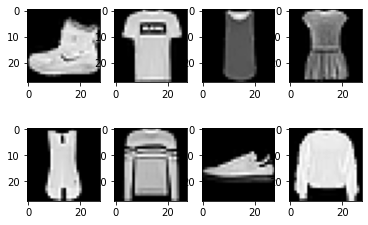

In [63]:
%matplotlib inline

import matplotlib.pyplot as plt

for i in range(8):
    plt.subplot(int(str(24)+str(i+1)))
    plt.imshow(train_set.train_data[i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

# Implement an Autoencoder

The next step is to implement a very simple autoencoder algorithm. 

Recall from the lecture, an autoencoder is an unsupervised algorithm that consists of an encoder and a decoder. The input passes through an encoder, which typically contains a bottleneck to reduce to the dimensionality of the input. This latent code, or reduced dimensionality representation of the input is then passed through the decoder to reconstruct the input. The reconstruction will be a lossy version of the input. The encoder and decoder are neural networks and learning is achieved in the same manner as with a neural network.

For this implementation, assume the Encoder (defined below) only has an input and an output. There is no hidden layer in the encoder. Assume the dimensionality of the latent space is $64$.

For the Decoder, again, assume it is a simple dense layer without a hidden layer (simply an input and output layer). For the decoder, the output layer should have a Sigmoid non-linearity as opposed to Relu (which may be used for the other layers).

Start by defining the Encoder and Decoder classes. 

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, hidden_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim, hidden_dim=512):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out
    
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

enc_dim = 2
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

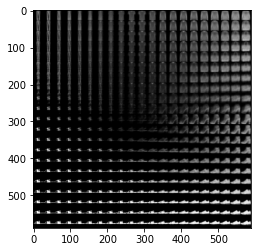

In [74]:
# Random images generated from prior sampling
width, height = 28, 28
samples = 21
images = torch.zeros((height * samples, width * samples))
x = torch.linspace(-4, 4, samples)
y = torch.linspace(4, -4, samples)
for i in range(samples):
    for j in range(samples):
        z = torch.tensor((x[i],y[j])).unsqueeze(0)
        out = dec(z)
        out = out.detach().reshape(28,28)
        images[j*height:(j+1)*height, i*width:(i+1)*width] = out
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.savefig("ae_sample.png")

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, hidden_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim, hidden_dim=512):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

Next, let's test the autoencoder implementation to make sure it is functioning and see what the reconstructed images look like.

The code to test your autoencoder is written below. You will simply need to write the code to display your reconstructed images. 

In [80]:
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

enc_dim = 2
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

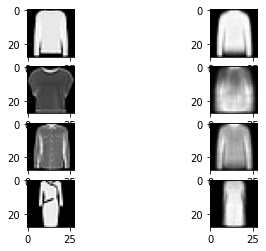

In [67]:
%matplotlib inline

import matplotlib.pyplot as plt
import random

cnt = 4
n = 0
show = list(zip(inputs, outputs))
random.shuffle(show)
for i in range(cnt):
    inp, out = show[i]
    n += 1
    plt.subplot(cnt, 2, n)
    img = inp.reshape(28,28)
    plt.imshow(img.detach().numpy(), cmap=plt.get_cmap('gray'))
    n += 1
    plt.subplot(cnt, 2, n)
    noisy_img = out.reshape(28,28)
    plt.imshow(noisy_img.detach().numpy(), cmap=plt.get_cmap('gray'))

plt.show()   

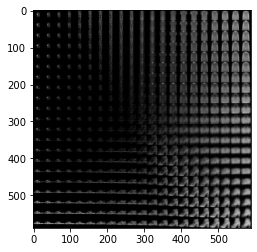

In [81]:
# Random images generated from prior sampling
width, height = 28, 28
samples = 21
images = torch.zeros((height * samples, width * samples))
x = torch.linspace(-4, 4, samples)
y = torch.linspace(4, -4, samples)
for i in range(samples):
    for j in range(samples):
        z = torch.tensor((x[i],y[j])).unsqueeze(0)
        out = dec(z)
        out = out.detach().reshape(28,28)
        images[j*height:(j+1)*height, i*width:(i+1)*width] = out
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.savefig("ae_sample2.png")

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        return out

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim, hidden_dim=512):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out
    
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

enc_dim = 2
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

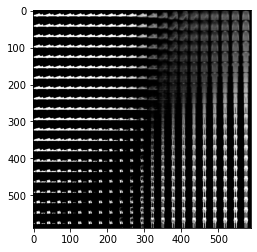

In [88]:
# Random images generated from prior sampling
width, height = 28, 28
samples = 21
images = torch.zeros((height * samples, width * samples))
x = torch.linspace(-4, 4, samples)
y = torch.linspace(4, -4, samples)
for i in range(samples):
    for j in range(samples):
        z = torch.tensor((x[i],y[j])).unsqueeze(0)
        out = dec(z)
        out = out.detach().reshape(28,28)
        images[j*height:(j+1)*height, i*width:(i+1)*width] = out
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.savefig("ae_sample3.png")

# Part 2: Denoising Autoencoder

In [11]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

### Extend the Autoencoder you implemented in Part 1 to a Denoising Autoencoder

Recall from the lecture, a denoising autoencoder's architecture is very similar to a standard autoencoder. The difference is the input to the autoencoder has noise added to it. However, when computing the loss function, make sure the original (non-noisy) version is used for backpropagation.

Again, let's start by loading the Fashion-MNIST dataset and transforming it to a flattened tensor.

In [12]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

import numpy as np

batch_size = 256
image_dim = 784  # [flattened]

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

## Build a Denoising Autoencoder
Now, define the Encoder and Decoder classes for your denoising autoencoder, called DN_Encoder, DN_Decoder, respectively. You can define these architectures how you like; some suggested architectures are given as comments in the classes below.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain


class DN_Encoder(nn.Module):
    '''
    Denoising encoder with a single input, hidden and output layer
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)       
        out = self.fc2(out)
        out = F.relu(self.fc3(out))
        return out

        
class DN_Decoder(nn.Module):
    '''
    Denoising decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)   
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

## Learning your Denoising Autoencoder 

Start from the training procedure used in Part 1 for the autoencoder and extend this to get your denoising autoencoder working. Again, include images of both the data with added noise as well as the reconstructed images in the submitted notebook. Regarding the noise to add to your images, add Gaussian noise with a mean of 0 and a standard deviation of 1.

In [14]:
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

enc_dim = 64
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = DN_Encoder(image_dim, 100, enc_dim)
dec = DN_Decoder(enc_dim, 100, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        noisy_inputs = inputs + torch.randn(inputs.shape)
        optimizer.zero_grad()

        z = enc(noisy_inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

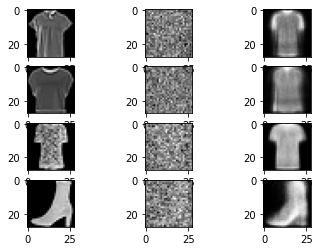

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

cnt = 4
n = 0

for i in range(cnt):
    n += 1
    plt.subplot(cnt, 3, n)
    img = inputs[i].reshape(28,28)
    plt.imshow(img.detach().numpy(), cmap=plt.get_cmap('gray'))
    n += 1
    plt.subplot(cnt, 3, n)
    noisy_img = noisy_inputs[i].reshape(28,28)
    plt.imshow(noisy_img.detach().numpy(), cmap=plt.get_cmap('gray'))
    n += 1
    plt.subplot(cnt, 3, n)
    clean_img = outputs[i].reshape(28,28)
    plt.imshow(clean_img.detach().numpy(), cmap=plt.get_cmap('gray'))

plt.show()

# Part 3: Variational Autoencoders (VAE)

For this part of the lab, you will implement a VAE. There is some code below which will help you run the learning procedure, however, you will need to complete the definition of the loss function. Start by implementing the encoder and decoder for the VAE. There is a diagram below illustrating what these architectures should look like.

Let's start by loading the Fashion-MNIST dataset again and transforming the data to a flattened tensor.

### Loading the Dataset

In [31]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [32]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

## Build a Simple Variational Autoencoder

<img src="http://comp6248.ecs.soton.ac.uk/labs/lab8/VAE_resized.png">

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer (ReLU activation)
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, embedding_dim)
        self.sigma = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        mu = self.mu(out)
        sigma = self.sigma(out)
        return mu, sigma

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''

    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

## You may complete the code below to test your implementation, or alternately, rewrite your own.

#### Once you've trained the network plot some reconstructions side-by-side with the original images and reflect on how good the reconstructions are (or aren't!). Also try generating some random images by sampling the prior and feeding the vectors to the decoder.

In [34]:
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps

#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        
        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        # https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
        kl = torch.sum(log_sigma2.exp() + mu.pow(2) - 1 - log_sigma2) / 2
        kl /= batch_size * image_dim

        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

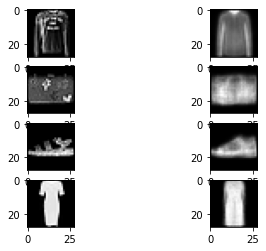

In [38]:
## Display some of the reconstructed images

import matplotlib.pyplot as plt
import random

cnt = 4
n = 0
show = list(zip(inputs, outputs))
random.shuffle(show)
for i in range(cnt):
    inp, out = show[i]
    n += 1
    plt.subplot(cnt, 2, n)
    img = inp.reshape(28,28)
    plt.imshow(img.detach().numpy(), cmap=plt.get_cmap('gray'))
    n += 1
    plt.subplot(cnt, 2, n)
    noisy_img = out.reshape(28,28)
    plt.imshow(noisy_img.detach().numpy(), cmap=plt.get_cmap('gray'))

plt.show()

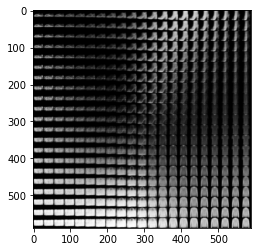

In [39]:
# Random images generated from prior sampling
w, h = 28, 28
cnt = 21
sample_img = torch.zeros((h * cnt, w * cnt)) # HW
for xi, x_prior in enumerate(torch.linspace(-4, 4, cnt)):
    for yi, y_prior in enumerate(torch.linspace(4, -4, cnt)):
        z = torch.tensor((x_prior, y_prior)).unsqueeze(0)
        output = dec(z)
        output = output.detach().reshape(28,28)
        sample_img[yi*h:yi*h+h, xi*w:xi*w+w] = output
plt.imshow(sample_img, cmap=plt.get_cmap('gray'))
plt.savefig("vae_sample.png")

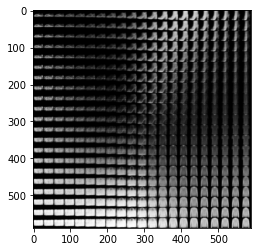

In [60]:
# Random images generated from prior sampling
width, height = 28, 28
samples = 21
images = torch.zeros((height * samples, width * samples))
x = torch.linspace(-4, 4, samples)
y = torch.linspace(4, -4, samples)
for i in range(samples):
    for j in range(samples):
        z = torch.tensor((x[i],y[j])).unsqueeze(0)
        out = dec(z)
        out = out.detach().reshape(28,28)
        images[j*height:(j+1)*height, i*width:(i+1)*width] = out
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.savefig("vae_sample.png")